<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/solutions/module-03-02_RL-Exercises-Solutions.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# RL Exercises

These exercises were inspired by and adapted from [Models of Learning](http://www.hannekedenouden.ruhosting.nl/RLtutorial/Instructions.html) by Jill O'Reilly and Hanneke den Ouden, [NSCS 344 - Modeling the Mind](http://u.arizona.edu/~bob/web_NSCS344) by Robert C. Wilson, [NSCI 526 - Tutorial 2 (Reinforcement Learning)](https://github.com/shawnrhoads/gu-nsci-526) by Shawn Rhoads, the [Gambling Game tutorial](https://github.com/cloudssty), and the [Neuromatch Academy tutorials](https://github.com/NeuromatchAcademy/course-content) [[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)].

In these exercises, we will fit learning behavior to the Rescorla Wagner model of Reinforcement Learning. The data can be downloaded from [GitHub](https://github.com/shawnrhoads/gu-psyc-347/raw/editing/docs/static/data/RL-Exercises-Data.zip) or by simply running the code below.

## Table of Contents
**Part 1**

1. [Getting to know your stimuli](#getting-to-know-your-stimuli)
2. [Exploring behavior](#exploring-behavior)
3. [Exploring outcomes](#exploring-outcomes)

**Part 2**

4. [Defining a likelihood function](#defining-a-likelihood-function)
5. [Minimizing the negative loglikelihood](#minimizing-the-negative-loglikelihood)
6. [Comparing results with your predictions](#comparing-results-with-your-predictions)

#### Key
- `# [INSERT CODE BELOW]` : indicates where you should insert your own code, feel free to replace with a comment of your own
- `...`: indicates a location where you should insert your own code
- `raise NotImplementedError("Student exercise: *")` : delete this line once you have added your code

<hr>

## Part 1
You will break out in groups of 2-3 to discuss the following questions (<font color='red'>highlighted in red font</font>) and implement code to answer them. I have prepared a few functions that will help you along the way.

Then, we will re-group with the entire class to discuss what we've learned. Please remember to save your work. This will count towards your Jupyter Notebook Exercise #3 grade.

In [1]:
# first let's import our packages

from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
# this function will load the data into memory (assuming that
# the data are downloaded)
def load_subjects(how_many=15):
    '''
    input: number of subjects' data to load from 1-14
    output: dictionary of DataFrames containing the data
    '''
    
    assert (how_many > 0) and (how_many <= 15), "0 < how_many < 15"
    
    if os.path.isdir('../static/data'):
        files = [f'../static/data/sub-{x:02}_RLdata.csv' for x in range(0,how_many)]
    else:
        files = [f'sub-{x:02}_RLdata.csv' for x in range(0,how_many)]
    
    subject_data = {}
    for index, file in enumerate(files):
        subject_data[index] = pd.read_csv(file, index_col=0)
    
    return subject_data

In [3]:
# let's load in our data using the function above
# feel free to adjust `how_many` (the default is all 15 subjects)
subject_data = load_subjects()

### 1. Getting to know your stimuli

Subjects played a few rounds of the two-armed bandit task, in which they learned the reward probability distribution of two slot machines (**stim_A** and **stim_B**) through trial-and-error. 

<font color="red">1a. How many trials did each subject complete?</font> (*Hint: explore the Dictionary of DataFrames*)

In [4]:
for subject_behavior in subject_data.values():
    print(len(subject_behavior), end=" trials, ")

50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 50 trials, 

**ANSWER 1a:** 

Each subject completed 50 trials corresponding to 50 rows in each DataFrame.

Each slot machine was associated with a different mean probability (i.e., **stim_A** yielded rewards according to a constant probability and **stim_B** yielded rewards according to a different constant probability). 

<font color="red">1b. What were the probabilities of each stimulus?<br>
1c. Did **stim_A** have the same probability for every subject? **stim_B**? Why or why not?</font>

In [5]:
display(subject_data[0].head()) # first subject head
display(subject_data[2].head()) # third subject head

,stim_A,stim_B,choice,outcome
0,0.2,0.8,0,0
1,0.2,0.8,0,0
2,0.2,0.8,0,0
3,0.2,0.8,1,1
4,0.2,0.8,1,0


,stim_A,stim_B,choice,outcome
0,0.8,0.2,0,1
1,0.8,0.2,0,1
2,0.8,0.2,0,1
3,0.8,0.2,0,0
4,0.8,0.2,0,1


**ANSWER 1b:**

Each stimulus yielded rewards with either a 20% or 80% chance.

**ANSWER 1c:**

The stimuli displayed to subject #1 have different probabilities than the stimuli displayed to subject #3. The probabilities of yielding rewarding outcomes are randomly assigned to each stimulus for each subject because we don't want learning to be confounded with the ***stimuli***. For example, that means we don't want it to be the case that learning for a red stimulus is easiest across subjects and thus confounded stimulus type would be confounded with learning (see lecture from 3/2/2021).

### 2. Exploring behavior

People learn (or don't) in many different ways. Some people are extremely sensitive when outcomes aren't what they expected. Others aren't willing to update their behaviors so quickly.

People also make decisions differently. Some people are more explorative and are event willing to try a riskier action just to see what happens. Others are more "deterministic" with their actions tend to stick with what they know is best.

While there are plenty more ways people vary in their learning and decision-making behavior, we are going to explore these two aspects. 

*Hint: please use the `plot_behavior()` function to explore different aspects of subjects' behavior and outcomes*

In [6]:
def plot_behavior(subject_data, subject_id, choices=False, outcomes=False, probability=False):
    '''
    input: 
        subject_data: dictionary containing
        subject_id: integer from 0-14 corresponding to an ID number
        choices: boolean indicating whether to plot choices or not
        outcomes: boolean indicating whether to plot outcomes or not
        probability: boolean indicating whether to plot the mean reward over trials for both stimuli or not
    output:
        plot of behavior
    '''
    assert type(subject_data) is dict, "`subject_data` should be a dictionary, run the `load_subjects()` function above to load the data into memory"
    assert type(subject_id) is int and subject_id >= 0 and subject_id <= 14, "`subject_id` should be an integer between 0 and 14"
    
    data = subject_data[subject_id]
    
    if probability:
        plt.axhline(np.mean(data[data.choice==0].outcome), color="orange", alpha=.4, label=data.columns[0])
        plt.axhline(np.mean(data[data.choice==1].outcome), color="purple", alpha=.4, label=data.columns[1])
        
    if outcomes:
        plt.plot(range(len(data)), data.outcome, 'r--', alpha=.6, label='outcome')
    if choices:
        if np.mean(data.choice) < .5:
            choice_data = [0 if x == 1 else 1 for x in data.choice]
        else:
            choice_data = [x for x in data.choice]
        plt.plot(range(len(data)), choice_data, '+', label='choice')
    
    plt.xlabel('trials')
    plt.ylabel('outcome')
    plt.title(f'Behavior from subject #{subject_id}')
    plt.legend()
    plt.show()

Plot everyone's behavior and answer the following questions (*pro-tip: there's way to plot everyone's data using only two lines of code; can you figure it out?*).
<br><br>

<font color="red">
    2a. Which subjects were most sensitive to previous unexpected outcomes? In other words, who changed their decisions most often after a prediction error? List the subject ID numbers. Describe which aspect(s) of the data led you to this conclusion. What parameter from the Rescorla-Wagner Model captures this tendency?<br>
    2b. Which subjects were least explorative in their behavior? List the subject ID numbers. Describe which aspect(s) of the data led you to this conclusion. What parameter from the Rescorla-Wagner Model captures this tendency?</font>

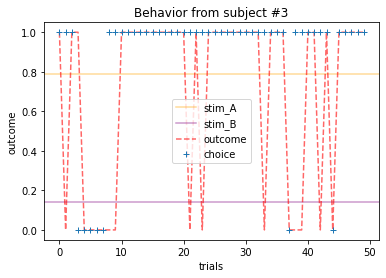

In [7]:
# one subject
plot_behavior(subject_data, 3, choices=True, outcomes=True, probability=True)

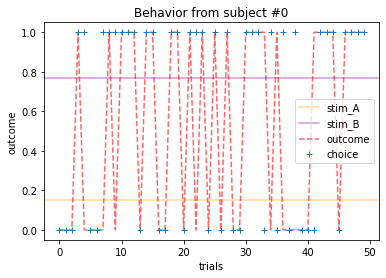

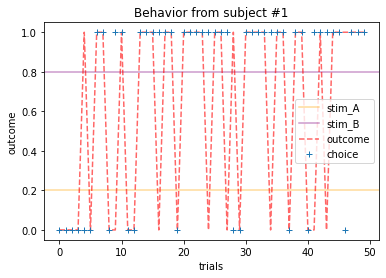

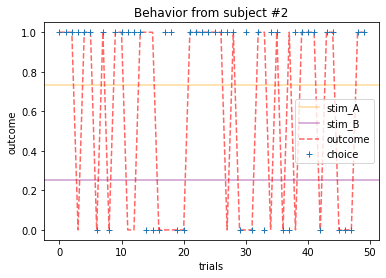

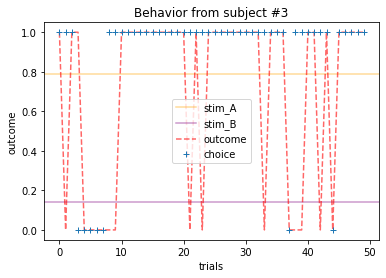

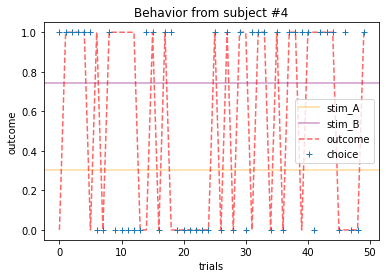

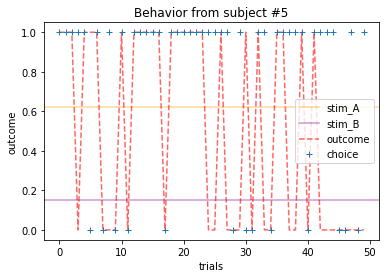

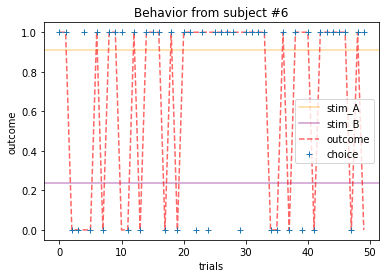

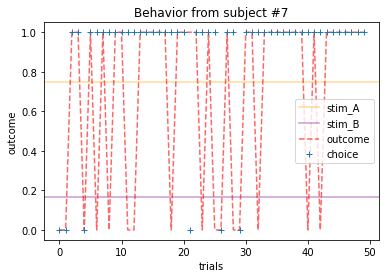

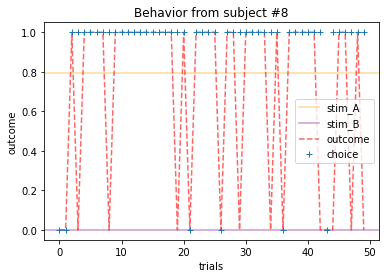

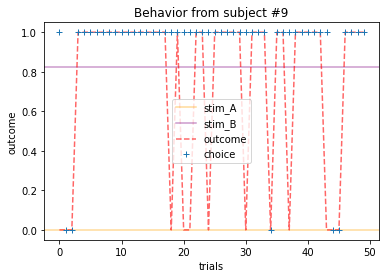

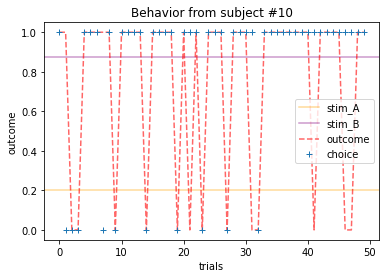

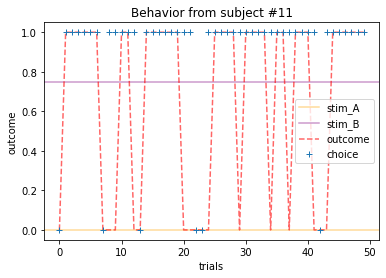

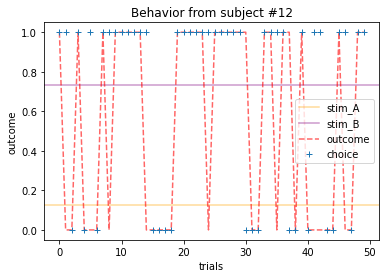

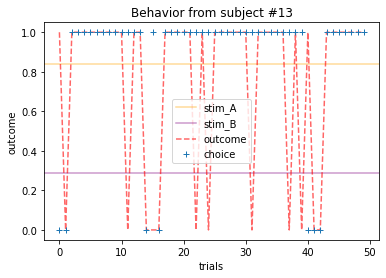

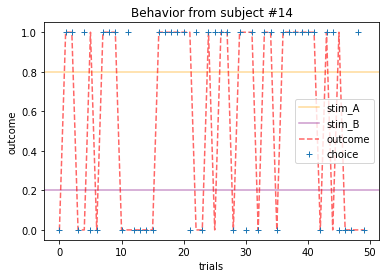

In [8]:
# all subjects
for x in range(15):
    plot_behavior(subject_data, x, choices=True, outcomes=True, probability=True)

# all subjects using in one line of code [plot_behavior(subject_data, x, choices=True, outcomes=True, probability=True) for x in range(15)]

**ANSWER 2a:**

Subjects that changed their choices most often after they (1) selected the stimulus with the highest probability of yielding reward but did not receive a rewarding outcome or (2) selected the stimulus with the lowest probability of yielding reward, but did in-fact receive a rewarding outcome. For example, see  plots for subjects 4, 10, 12, and 14.

**ANSWER 2b:**

Subejcts that were less explorative were those who were less likely to select the stimulus with the lowest probability of yielding reward after they learned the association. They were people who selected stimuli more randomly during early trials, but eventually almost always selected the better option. For example, see  plots for subjects 1, 3, 7, 9, and 13.


### 3. Exploring outcomes

<font color="red">Earlier, we learned that the reward probabilities of each stimulus were fixed, how do these values compare with the actual mean reward over trials across subjects (according to their choices)? Are they similar? Why or why not?</font> (*Hint: see plots above and/or explore different subjects' "outcome" column*)<br>


In [9]:
for i, s in enumerate(subject_data.values()):
    print(f'subject {i}')
    if s.stim_A.mean() > .5: # only print high probability stimulus
        print(f'probability that stim A yielded reward: {s.stim_A.mean():.2f}')
        print(f'actual frequency of choosing stim A: {1 - s.choice.mean():.2f}')
        print(f'actual mean reward: {s.outcome.mean():.2f}')
    else:
        
        print(f'probability that stim B yielded reward: {s.stim_B.mean():.2f}')
        print(f'actual frequency of choosing stim B: {s.choice.mean():.2f}')
        print(f'actual mean reward: {s.outcome.mean():.2f}')
    print()

subject 0
probability that stim B yielded reward: 0.80
actual frequency of choosing stim B: 0.60
actual mean reward: 0.52

subject 1
probability that stim B yielded reward: 0.80
actual frequency of choosing stim B: 0.70
actual mean reward: 0.62

subject 2
probability that stim A yielded reward: 0.80
actual frequency of choosing stim A: 0.68
actual mean reward: 0.58

subject 3
probability that stim A yielded reward: 0.80
actual frequency of choosing stim A: 0.86
actual mean reward: 0.70

subject 4
probability that stim B yielded reward: 0.80
actual frequency of choosing stim B: 0.54
actual mean reward: 0.54

subject 5
probability that stim A yielded reward: 0.80
actual frequency of choosing stim A: 0.74
actual mean reward: 0.50

subject 6
probability that stim A yielded reward: 0.80
actual frequency of choosing stim A: 0.66
actual mean reward: 0.68

subject 7
probability that stim A yielded reward: 0.80
actual frequency of choosing stim A: 0.88
actual mean reward: 0.68

subject 8
probab

**ANSWER 3:**

The mean values of the actual outcomes/rewards are more similar to the actual probabilities when people learned the associative values (i.e., they are closer to .80), but deviated when people did not learn to choose the stimuli with the higher reward probability as well. Participants learned if the frequency of choosing the stimulus that yielded the higher reward was >50%. See above.

Great job! Don't forget to save any of your work. It will also be useful for **Part 2**!

<hr>

## Part 2

Now that we have explored the data and gotten a sense about participants' behaviors during the task, let's estimate models that explain their learning!

We will:
- Define a function that computes the negative loglikelihood given the data and Rescorla-Wagner Model 
- Implement an minimization algorithm that loops through possible combinations of $\alpha$ and $\theta$ for each subject in order to find the parameters that minimize the negative loglikelihood. Each subject ($i$) will have a separate set of parameters $\alpha_i$ and $\theta_i$, which respectively correspond to the learning rate and inverse temperature 
- Compare the estimated parameter values for $\alpha_i$ and $\theta_i$ to your initial predictions in Questions [#2a-b](#2.-Exploring-behavior).

### 4. Defining a likelihood function

Recall that our goal is to find the parameter values of a model that maximize the likelihood of the data. In the Rescorla-Wagner case, we want to maximize the likelihood (a.k.a. minimize the loglikelihood) of the data given parameter values ($\alpha$ and $\theta$) of the model.

In the Rescorla-Wagner Model, the likelihood of the data are given by the probability of making a choice on a give trial, $p(c_t)$. 

That is, participants use the stimuli values to guide their decisions, choosing the most valuable option most frequently, but occasionally making 'mistakes' (or exploring) by choosing a low value option. One choice rule with these properties is known as the **'softmax' choice rule**, which chooses option $k$ with probability:

$$
p^k_t = \frac{\exp(\theta Q^k_t)}{\sum_{i=1}^K \exp(\theta Q^i_t)}
$$

where $\theta$ is the 'inverse temperature' parameter that controls the level of stochasticity in the choice, ranging from $\theta = 0$ for completely random responding and $\theta = \infty$ for deterministically choosing the highest value option.

The value of each stimulus $k$, $Q^k_t$ is updated in response to reward $r_t$ according to:

$$
Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)
$$

where $\alpha$ is the learning rate, which is bounded between 0 and 1 and captures the extent to which the prediction error, $(r_t - Q^k_t)$, updates the value (i.e., a higher $\alpha$ value will put greater weight on the prediction error). For simplicity, we assume that the initial value, $Q^k_0=0$, although it is possible to treat the $Q^k_0$ as a free parameter of the model (this is also the intercept).

Combining the learning and decision rules gives a simple model of decision making in this task with two free parameters: the learning rate, $\alpha$, and the inverse temperature $\theta$.

Thus, for any given ($\alpha$ and $\theta$) of the model, the negative loglikelihood $negative \log \mathcal{L}$ will be computed as:

$$
negative \log \mathcal{L} = -\sum_{t=1}^T \log p(c_t)
$$

Below we will define a function that computes the negative loglikelihood given the data and Rescorla-Wagner Model (see [Intro to Python](https://shawnrhoads.github.io/gu-psyc-347/module-01-01_Intro-to-Python.html) for functions, [Modeling Exercises](https://shawnrhoads.github.io/gu-psyc-347/module-02-02_Modeling-Exercises.html) and [Models of Learning](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html) for negative loglikelihood, and [Models of Learning](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html) for the Rescorla-Wagner Model).

```
# fill in the `...` below to estimate model params for each subject

def negll_RescorlaWagner(params, choices, outcomes):

    # [INSERT CODE BELOW]
    raise NotImplementedError("Student exercise: complete the code below to define that computes the negative loglikelihood for the Rescorla-Wagner Model of Learning, then delete this line")

    alpha, theta = params 
    
    if np.isnan(alpha) or np.isnan(theta): # check inputs
        return np.inf
    
    else:
        c, r = choices, outcomes 

        T = len(c) 
        Q = [0.5, 0.5] # Q at trial 0
        Q_stored = np.zeros((2, T), dtype = float) 
        choiceProb = np.zeros((T), dtype = float) 

        for t in range(T): # add comment

            # compute choice probabilities for k=2
            # use the softmax rule
            ev = np.exp(theta*np.array(Q))
            sum_ev = np.sum(ev)
            p = ev / sum_ev

            # compute choice probability for actual choice
            choiceProb[t] = p[c[t]] 

            # update values
            delta = r[t] - Q[c[t]]
            Q[c[t]] = Q[c[t]] + alpha * ...

            # store Q_t+1
            Q_stored[:,t] = Q

        negLL = -np.sum(np.log(choiceProb)) 
    
        return negLL
```

In [10]:
# solution

def negll_RescorlaWagner(params, choices, outcomes):
    
    alpha, theta = params 
    
    if np.isnan(alpha) or np.isnan(theta): # check inputs
        return np.inf
    
    else:
        c, r = choices, outcomes 

        T = len(c) 
        Q = [0.5, 0.5] # Q at trial 0
        Q_stored = np.zeros((2, T), dtype = float) 
        choiceProb = np.zeros((T), dtype = float) 

        for t in range(T): # add comment

            # compute choice probabilities for k=2
            # use the softmax rule
            ev = np.exp(theta*np.array(Q))
            sum_ev = np.sum(ev)
            p = ev / sum_ev

            # compute choice probability for actual choice
            choiceProb[t] = p[c[t]] 
            
            # update values
            delta = r[t] - Q[c[t]]
            Q[c[t]] = Q[c[t]] + alpha * delta

            # store Q_t+1
            Q_stored[:,t] = Q

        negLL = -np.sum(np.log(choiceProb)) # add comment
    
        return negLL

Let's develop an intuition for how this function works. Make a guess for subejct #3's $\alpha$ and $\theta$ to compute the negative loglikelihood.

```
# fill in the `...` below to make guess for alpha and theta for subject #3
# then, fill in the inputs for the function

# [INSERT CODE BELOW]
raise NotImplementedError("Student exercise: make guess for alpha and theta to compute the negative loglikelihood, then delete this line")

alpha_guess = ... #number between 0-1
theta_guess = ... #number between 1-8
subj3_choices = subject_data[3].choice
subj3_outcomes = subject_data[3].outcome

# compute the negative ll
subj3_negll = negll_RescorlaWagner([..., ...], subj3_choices, subj3_outcomes)
print(f'given alpha={alpha_guess} and theta={theta_guess}, the negative loglikelihood is {subj3_negll:.2f}')
```

In [11]:
# solution

alpha_guess = .1
theta_guess = 1.5
subj3_choices = subject_data[3].choice
subj3_outcomes = subject_data[3].outcome

# compute the negative ll
subj3_negll = negll_RescorlaWagner([alpha_guess, theta_guess], subj3_choices, subj3_outcomes)
print(f'given alpha={alpha_guess} and theta={theta_guess}, the negative loglikelihood is {subj3_negll:.2f}')

given alpha=0.1 and theta=1.5, the negative loglikelihood is 25.91


### 5. Minimizing the negative loglikelihood

Now that we have a function, implement an minimization algorithm that loops through possible combinations of $\alpha$ and $\theta$ for each subject in order to find the parameters that minimize the negative loglikelihood. Each subject ($i$) will have a separate set of parameters $\alpha_i$ and $\theta_i$, which respectively correspond to the learning rate and inverse temperature (see [Models of Learning](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html)). 

Importantly, we will store these parameters in a Pandas DataFrame with 15 rows corresponding to subjects, and 2 columns corresponding to $\alpha$ and $\theta$ (see [Working with Data](https://shawnrhoads.github.io/gu-psyc-347/module-01-02_Working-with-Data.html) for more on Pandas DataFrames).

```
# fill in the `...` below to estimate model params for each subject

# [INSERT CODE BELOW]
raise NotImplementedError("Student exercise: complete the code below to estimate model parameters for each subject, then delete this line")

#initialize dataframe to store results
df = pd.DataFrame(index=range(0,len(subject_data)), columns=['alpha','theta'])

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    ..., ... = behavior.choice, behavior.outcome
    
    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha, theta
    for alpha_guess in np.linspace(0,1,3):
        for theta_guess in np.linspace(1,10,3):

            # guesses for alpha, theta will change on each loop
            init_guess = (..., ...)

            # minimize neg LL
            result = minimize(..., 
                              ..., 
                              (c, o), 
                              bounds=((0,1),(0,10)))

            # if current negLL is smaller than the last negLL,
            # then store current data
            if result.fun < res_nll:
                res_nll = ...
                param_fits = ...

    # also, compute BIC
    # note: we don't need the -1 because 
    # we already have the negative log likelihood!
    BIC = len(init_guess) * np.log(len(c)) + 2*res_nll
    
    #store in dataframe
    df.at[index, 'alpha'] = param_fits[0]
    df.at[index, 'theta'] = param_fits[1]
    
    print(fr'subject {index:02}: $\alpha$={param_fits[0]:.2f}, $\theta$={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
```

In [12]:
# solution

#initialize dataframe
df = pd.DataFrame(index=range(0,len(subject_data)), columns=['alpha','theta'])
# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, r = behavior.choice, behavior.outcome
    
    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_guess in np.linspace(0,1,3):
        for theta_guess in np.linspace(1,10,3):

            # guesses for alpha, theta will change on each loop
            init_guess = (alpha_guess, theta_guess)

            # minimize neg LL
            result = minimize(negll_RescorlaWagner, 
                              init_guess, 
                              (c, r), 
                              bounds=((0,1),(0,10)))

            # if current negLL is smaller than the last negLL,
            # then store current data
            if result.fun < res_nll:
                res_nll = result.fun
                param_fits = result.x

    # also, compute BIC 
    # note: we don't need the -1 because 
    # we already have the negative log likelihood!
    BIC = len(init_guess) * np.log(len(c)) + 2*res_nll
    
    #store in dataframe
    df.at[index, 'alpha'] = param_fits[0]
    df.at[index, 'theta'] = param_fits[1]
    
    print(fr'subject {index:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')

subject 00: alpha=0.47, theta=0.74; negLL=33.17; BIC=74.16
subject 01: alpha=0.06, theta=3.77; negLL=26.89; BIC=61.61
subject 02: alpha=0.31, theta=1.55; negLL=32.05; BIC=71.92
subject 03: alpha=0.16, theta=5.41; negLL=16.37; BIC=40.57
subject 04: alpha=0.79, theta=0.64; negLL=33.92; BIC=75.67
subject 05: alpha=0.38, theta=3.38; negLL=25.08; BIC=57.98
subject 06: alpha=0.07, theta=1.66; negLL=32.01; BIC=71.84
subject 07: alpha=0.18, theta=6.61; negLL=14.13; BIC=36.08
subject 08: alpha=0.44, theta=3.33; negLL=16.04; BIC=39.90
subject 09: alpha=0.76, theta=4.02; negLL=12.24; BIC=32.29
subject 10: alpha=0.02, theta=10.00; negLL=21.33; BIC=50.48
subject 11: alpha=0.62, theta=4.22; negLL=13.96; BIC=35.75
subject 12: alpha=0.85, theta=1.76; negLL=27.51; BIC=62.84
subject 13: alpha=0.63, theta=5.20; negLL=10.80; BIC=29.43
subject 14: alpha=1.00, theta=1.30; negLL=29.02; BIC=65.86


### 6. Comparing results with your predictions

How were your predictions? <font color="red">Do these parameters somewhat map onto what you expected solely based on their behavior?</font> It's okay if they didn't!

**ANSWER 6:**

Depends on students' answers to question 2a and 2b above.